In [108]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint


In [109]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [110]:
# spacy for lemmatization
import spacy

In [111]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

In [112]:
%matplotlib inline

In [113]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [114]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [115]:
# NLTK Stop words
# import nltk
# nltk.data.path.append("/home2/artur/artur-ssd.old/nltk_data")
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [116]:
# Import Dataset
df = pd.read_json('2w.json')
df.head()

,1
0,
1,
2,The Personal Is Political
3,by Carol Hanisch
4,


In [117]:
# Convert to list
data = df.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', str(sent)) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['[]']


In [118]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[[]]


In [119]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

[]


In [120]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [121]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load('en', disable=['parser', 'ner'])

# python3 -m spacy download en_core_web_sm
import en_core_web_sm
nlp = en_core_web_sm.load()

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[[]]


In [122]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[]]


In [123]:
id2word[0]

'personal'

In [124]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[]]

In [125]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [126]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.321*"experience" + 0.149*"pay" + 0.021*"psychological" + 0.000*"often" + '
  '0.000*"form" + 0.000*"speak" + 0.000*"seek" + 0.000*"never" + 0.000*"worth" '
  '+ 0.000*"treasure"'),
 (1,
  '0.202*"allow" + 0.088*"meet" + 0.000*"destroy" + 0.000*"victim" + '
  '0.000*"devour" + 0.000*"protesting" + 0.000*"gaze" + 0.000*"weakness" + '
  '0.000*"passivity" + 0.000*"turn"'),
 (2,
  '0.384*"would" + 0.155*"male" + 0.127*"well" + 0.070*"good" + 0.027*"raise" '
  '+ 0.027*"end" + 0.020*"together" + 0.020*"usually" + 0.007*"deal" + '
  '0.000*"feel"'),
 (3,
  '0.163*"real" + 0.087*"fight" + 0.073*"personal" + 0.054*"lot" + '
  '0.033*"courage" + 0.000*"feel" + 0.000*"situation" + 0.000*"even" + '
  '0.000*"self" + 0.000*"value"'),
 (4,
  '0.252*"many" + 0.160*"new" + 0.108*"far" + 0.071*"year" + 0.036*"do" + '
  '0.029*"especially" + 0.021*"note" + 0.016*"left" + 0.010*"second" + '
  '0.000*"love"'),
 (5,
  '0.147*"individual" + 0.143*"idea" + 0.120*"put" + 0.103*"old" + '
  '0.060*"c

In [127]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


Perplexity:  -24.900254100173022

Coherence Score:  0.4009677102421863


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17    -0.408318  0.242027       1        1  22.306202
19    -0.086518 -0.066669       2        1   9.883419
10    -0.150345 -0.294076       3        1   9.768447
13    -0.105810 -0.103506       4        1   8.890718
2     -0.114077 -0.124222       5        1   6.615395
16     0.009388  0.012138       6        1   5.328912
4      0.024163  0.017537       7        1   5.184038
14    -0.014025  0.001159       8        1   4.844700
11     0.033914  0.020550       9        1   4.522010
5      0.038677  0.021866      10        1   4.390898
18     0.031052  0.019628      11        1   3.591724
7      0.059233  0.026244      12        1   3.244869
15     0.060201  0.026456      13        1   2.678018
6      0.064839  0.027194      14        1   2.489820
3      0.093502  0.029302      15        1   1.580722
8      0.079276  0.028856      16        1   1.232561
12     0.098526  0.028980      17        1   1.170878
0      0.084394  0.029196      18        1   1.160728
9      0.100375  0.028744      19        1   0.678551
1      0.101554  0.028598      20        1   0.437400, topic_info=         Term          Freq         Total Category  logprob  loglift
13      woman  30372.000000  30372.000000  Default  30.0000  30.0000
117       man  12350.000000  12350.000000  Default  29.0000  29.0000
150     would   5241.000000   5241.000000  Default  28.0000  28.0000
149      take   4700.000000   4700.000000  Default  27.0000  27.0000
57       work   3443.000000   3443.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
399      girl      0.045553      3.282848  Topic20  -9.8931   1.1545
527       one      0.045551      3.282344  Topic20  -9.8931   1.1546
488     great      0.045551      3.283040  Topic20  -9.8931   1.1544
1113  freedom      0.045551      3.282914  Topic20  -9.8931   1.1544
538    become      0.045551      3.284192  Topic20  -9.8931   1.1540

[854 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
123       1  0.986937  admit
108      16  0.959870  agree
104      20  0.980989  allow
34        2  0.999234   also
183      13  0.976465   base
...     ...       ...    ...
57        8  0.999227   work
82       16  0.997328  world
150       5  0.999483  would
48       19  0.993629  write
8         7  0.995937   year

[134 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 20, 11, 14, 3, 17, 5, 15, 12, 6, 19, 8, 16, 7, 4, 9, 13, 1, 10, 2])

In [128]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17    -0.408318  0.242027       1        1  22.306202
19    -0.086518 -0.066669       2        1   9.883419
10    -0.150345 -0.294076       3        1   9.768447
13    -0.105810 -0.103506       4        1   8.890718
2     -0.114077 -0.124222       5        1   6.615395
16     0.009388  0.012138       6        1   5.328912
4      0.024163  0.017537       7        1   5.184038
14    -0.014025  0.001159       8        1   4.844700
11     0.033914  0.020550       9        1   4.522010
5      0.038677  0.021866      10        1   4.390898
18     0.031052  0.019628      11        1   3.591724
7      0.059233  0.026244      12        1   3.244869
15     0.060201  0.026456      13        1   2.678018
6      0.064839  0.027194      14        1   2.489820
3      0.093502  0.029302      15        1   1.580722
8      0.079276  0.028856      16        1   1.232561
12     0.098526  0.028980      17        1   1.170878
0      0.084394  0.029196      18        1   1.160728
9      0.100375  0.028744      19        1   0.678551
1      0.101554  0.028598      20        1   0.437400, topic_info=         Term          Freq         Total Category  logprob  loglift
13      woman  30372.000000  30372.000000  Default  30.0000  30.0000
117       man  12350.000000  12350.000000  Default  29.0000  29.0000
150     would   5241.000000   5241.000000  Default  28.0000  28.0000
149      take   4700.000000   4700.000000  Default  27.0000  27.0000
57       work   3443.000000   3443.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
399      girl      0.045553      3.282848  Topic20  -9.8931   1.1545
527       one      0.045551      3.282344  Topic20  -9.8931   1.1546
488     great      0.045551      3.283040  Topic20  -9.8931   1.1544
1113  freedom      0.045551      3.282914  Topic20  -9.8931   1.1544
538    become      0.045551      3.284192  Topic20  -9.8931   1.1540

[854 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
123       1  0.986937  admit
108      16  0.959870  agree
104      20  0.980989  allow
34        2  0.999234   also
183      13  0.976465   base
...     ...       ...    ...
57        8  0.999227   work
82       16  0.997328  world
150       5  0.999483  would
48       19  0.993629  write
8         7  0.995937   year

[134 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 20, 11, 14, 3, 17, 5, 15, 12, 6, 19, 8, 16, 7, 4, 9, 13, 1, 10, 2])

In [129]:
import os
os.environ.update({'MALLET_HOME':r'C:/mallet/mallet-2.0.8/'})
mallet_path = 'C:/mallet/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [130]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(5,
  [('make', 0.11715962711474277),
   ('sexual', 0.0832086546207849),
   ('pleasure', 0.03567729312924387),
   ('object', 0.031073771435147887),
   ('seek', 0.029577626884566693),
   ('flesh', 0.026355161698699506),
   ('feminine', 0.025319369317527908),
   ('desire', 0.024398664978708712),
   ('study', 0.020946023708136724),
   ('passive', 0.014155829209345149)]),
 (13,
  [('woman', 0.17119533527696792),
   ('long', 0.06985422740524781),
   ('put', 0.023090379008746355),
   ('baby', 0.020058309037900873),
   ('bear', 0.018542274052478134),
   ('realize', 0.017959183673469388),
   ('continue', 0.01620991253644315),
   ('magazine', 0.014460641399416909),
   ('fight', 0.013411078717201166),
   ('decide', 0.012594752186588922)]),
 (1,
  [('male', 0.06685301653855114),
   ('body', 0.049732122059166085),
   ('female', 0.043559282552993246),
   ('individual', 0.03994875378523177),
   ('freedom', 0.027952480782669462),
   ('existence', 0.024341952014907988),
   ('recognize', 0.02375960866

In [131]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [132]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

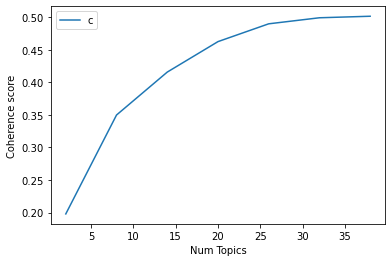

In [133]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [134]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.1981
Num Topics = 8  has Coherence Value of 0.3498
Num Topics = 14  has Coherence Value of 0.4157
Num Topics = 20  has Coherence Value of 0.4624
Num Topics = 26  has Coherence Value of 0.4897
Num Topics = 32  has Coherence Value of 0.499
Num Topics = 38  has Coherence Value of 0.5014


In [135]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.208*"woman" + 0.031*"create" + 0.020*"femininity" + 0.018*"reason" + '
  '0.017*"bear" + 0.014*"carry" + 0.014*"claim" + 0.011*"conflict" + '
  '0.011*"rise" + 0.010*"strength"'),
 (1,
  '0.101*"work" + 0.097*"time" + 0.066*"long" + 0.051*"year" + 0.046*"day" + '
  '0.026*"job" + 0.023*"full" + 0.018*"find" + 0.016*"part" + '
  '0.015*"movement"'),
 (2,
  '0.117*"girl" + 0.071*"young" + 0.036*"today" + 0.036*"boy" + 0.027*"future" '
  '+ 0.018*"describe" + 0.016*"situation" + 0.016*"people" + 0.015*"happen" + '
  '0.014*"happy"'),
 (3,
  '0.186*"man" + 0.136*"woman" + 0.056*"human" + 0.037*"real" + '
  '0.021*"relation" + 0.020*"define" + 0.018*"equal" + 0.018*"identity" + '
  '0.017*"person" + 0.012*"purpose"'),
 (4,
  '0.271*"woman" + 0.034*"american" + 0.032*"show" + 0.032*"image" + '
  '0.032*"housewife" + 0.027*"study" + 0.024*"career" + 0.017*"masculine" + '
  '0.015*"modern" + 0.015*"marry"'),
 (5,
  '0.028*"face" + 0.028*"write" + 0.027*"form" + 0.026*"freedom" + '
  

In [136]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.0500,"woman, create, femininity, reason, bear, carry...",[]
1,1,0.0,0.0500,"woman, create, femininity, reason, bear, carry...",[]
2,2,6.0,0.0865,"find, society, idea, change, friend, parent, i...",[The Personal Is Political]
3,3,0.0,0.0500,"woman, create, femininity, reason, bear, carry...",[by Carol Hanisch]
4,4,0.0,0.0500,"woman, create, femininity, reason, bear, carry...",[]
5,5,6.0,0.0664,"find, society, idea, change, friend, parent, i...",[INTRODUCTION]
6,6,0.0,0.0500,"woman, create, femininity, reason, bear, carry...",[]
7,7,0.0,0.0500,"woman, create, femininity, reason, bear, carry...",[January 2006]
8,8,0.0,0.0500,"woman, create, femininity, reason, bear, carry...",[]
9,9,6.0,0.1335,"find, society, idea, change, friend, parent, i...","[The paper, “The Personal Is Political,” was o..."


In [137]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1274,"woman, create, femininity, reason, bear, carry...",[Line” would be revised and misused. Like most...
1,1.0,0.1600,"work, time, long, year, day, job, full, find, ...",[full-time housewife still spent sixty hours a...
2,2.0,0.1257,"girl, young, today, boy, future, describe, sit...","[Night), accurately conveys the situation.18 T..."
3,3.0,0.1182,"man, woman, human, real, relation, define, equ...",[problems and unable to conceive of goals and ...
4,4.0,0.1370,"woman, american, show, image, housewife, study...","[brilliant careers, but poll after poll shows ..."


In [138]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"woman, create, femininity, reason, bear, carry...",7973.0,0.1561
1.0,0.0,"woman, create, femininity, reason, bear, carry...",3391.0,0.0664
2.0,6.0,"find, society, idea, change, friend, parent, i...",3146.0,0.0616
3.0,0.0,"woman, create, femininity, reason, bear, carry...",2361.0,0.0462
4.0,0.0,"woman, create, femininity, reason, bear, carry...",2382.0,0.0466
...,...,...,...,...
51080.0,4.0,"woman, american, show, image, housewife, study...",NaN,NaN
51081.0,0.0,"woman, create, femininity, reason, bear, carry...",NaN,NaN
51082.0,0.0,"woman, create, femininity, reason, bear, carry...",NaN,NaN
51083.0,0.0,"woman, create, femininity, reason, bear, carry...",NaN,NaN
